## Exploratory Data Analysis: Lung seg object
遍历所有Lung Seg的结果，对每一个object给不同的label，分析总的label分布，应该会出现两高峰表现，一边是Lung object；一边是噪声，需要crop之前进行去除。

In [6]:
import SimpleITK as sitk
import pandas as pd
from pathlib import Path
from tqdm import tqdm


# 输入：你的预处理数据目录
project_root = Path.cwd().resolve().parents[1]

source_dir = project_root / 'data' / '0_nifti'
all_seg_files = list(source_dir.glob("sub-*/*_seg-lung.nii.gz"))

# 用来存储所有结果
object_stats = []

for seg_file in tqdm(all_seg_files):
    try:
        subject = seg_file.parent.name
        
        mask = sitk.ReadImage(str(seg_file), sitk.sitkUInt8)
        
        # 1. 连通域分析
        cc_filter = sitk.ConnectedComponentImageFilter()
        labeled_mask = cc_filter.Execute(mask)
        
        # 2. 计算每个标签的统计信息
        label_stats_filter = sitk.LabelShapeStatisticsImageFilter()
        label_stats_filter.Execute(labeled_mask)
        
        labels = label_stats_filter.GetLabels()
        if 0 in labels:
            labels.remove(0) # 移除背景
            
        # 3. 记录每个物体的大小
        for label in labels:
            num_pixels = label_stats_filter.GetNumberOfPixels(label)
            object_stats.append({
                "Subject": subject,
                "label": label,
                "pixel_count": num_pixels
            })
            
    except Exception as e:
        print(f"Error processing {seg_file.name}: {e}")

# 4. 保存到CSV，方便后续分析
df = pd.DataFrame(object_stats)

output_analysis_csv_path = project_root / 'outputs' / 'data_statistics' / 'lung_object_size_distribution.csv'
df.to_csv(output_analysis_csv_path, index=False)
print(f"Analysis complete. Results saved to {output_analysis_csv_path}")

  0%|          | 3/1030 [00:00<05:37,  3.04it/s]

100%|██████████| 1030/1030 [03:49<00:00,  4.48it/s]

Analysis complete. Results saved to /home/yaobo/Project/Lung-Cancer-Subtyping-Classification-V4.0/outputs/data_statistics/lung_object_size_distribution.csv


count    5.057000e+03
mean     1.821906e+05
std      3.455098e+05
min      1.000000e+00
25%      2.000000e+00
50%      7.000000e+00
75%      3.013740e+05
max      4.294093e+06
Name: pixel_count, dtype: float64


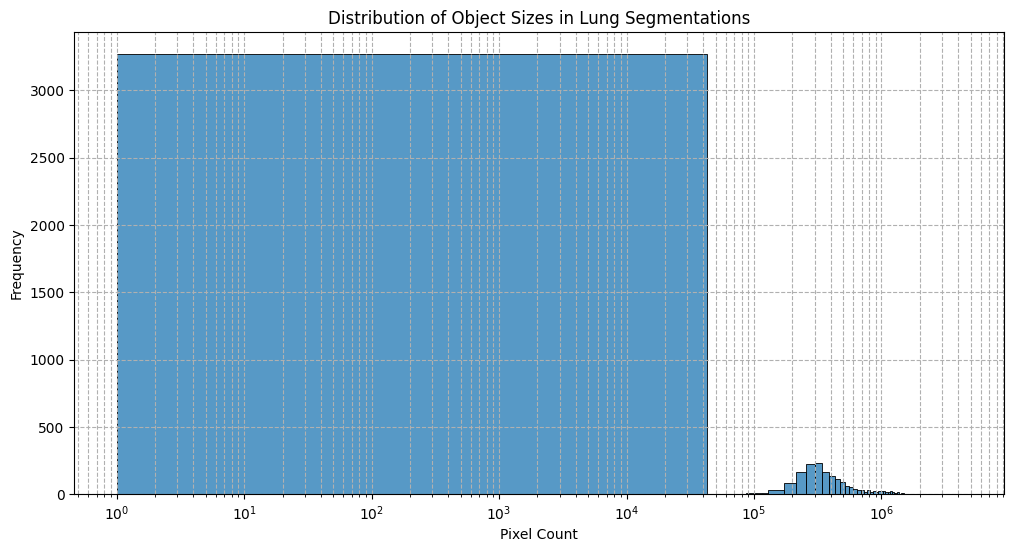

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv(output_analysis_csv_path)

# 1. 查看基础统计信息
print(df['pixel_count'].describe())

# 2. 绘制尺寸分布直方图
plt.figure(figsize=(12, 6))
sns.histplot(df['pixel_count'], bins=100, kde=False)
plt.title('Distribution of Object Sizes in Lung Segmentations')
plt.xlabel('Pixel Count')
plt.ylabel('Frequency')

# 3. **关键：使用对数坐标轴来观察**
# 因为噪声和肺叶的尺寸差异巨大，线性坐标轴下的小物体会挤在一起
plt.xscale('log') 
plt.grid(True, which="both", ls="--")
plt.show()